In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import re

plt.rcParams['figure.figsize'] = 21, 15
plt.rcParams['xtick.labelsize']=65
plt.rcParams['ytick.labelsize']=65
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update({'figure.autolayout': False})
plt.rcParams['axes.linewidth'] = 5
plt.rcParams['font.family'] = 'Arial'

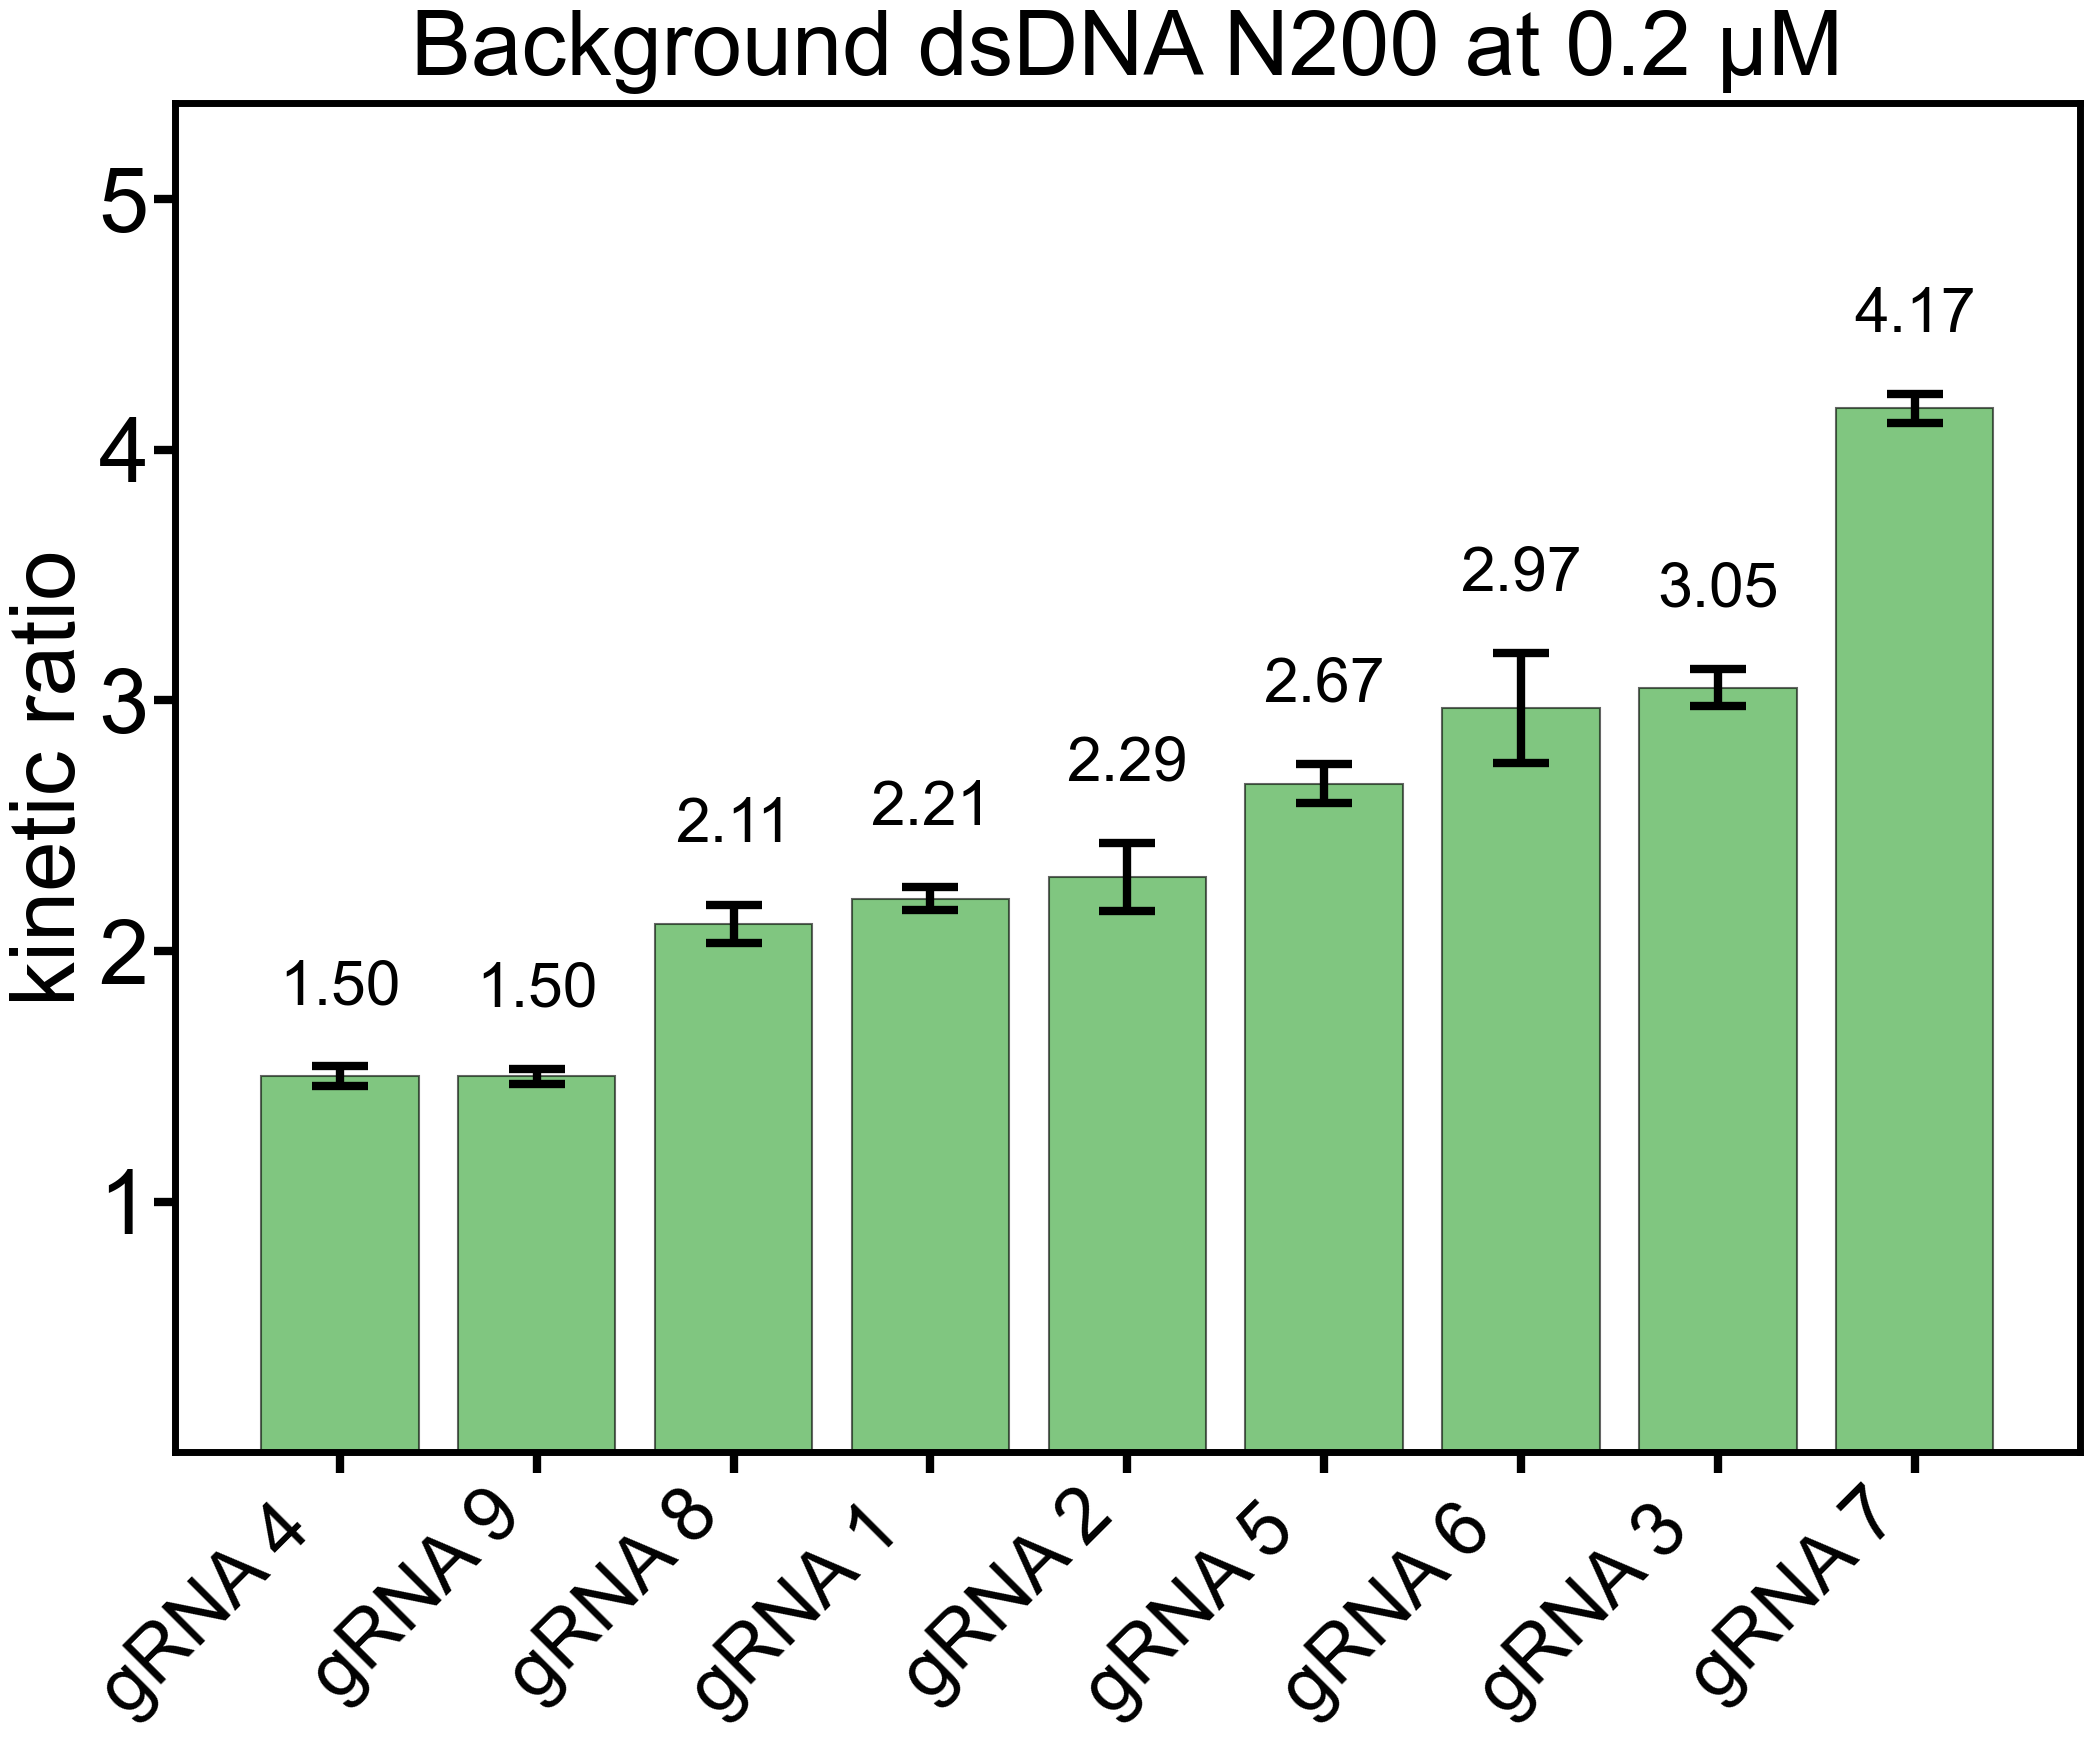

In [4]:
file_path = "Figure3-DNA-Background.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

dna_cols = [col for col in df.columns if "DNA" in col and col != "time"]
non_dna_cols = [col for col in df.columns if col not in dna_cols + ["time"]]

def group_triplicates(columns):
    grouped = defaultdict(list)
    for col in columns:
        base = col.replace(".1", "").replace(".2", "").strip()
        grouped[base].append(col)
    return grouped

dna_groups = group_triplicates(dna_cols)
non_dna_groups = group_triplicates(non_dna_cols)

def get_t100_times(df, group_cols):
    t100_dict = {}
    for key, cols in group_cols.items():
        times = []
        for col in cols:
            above = df[df[col] > 100]
            if not above.empty:
                times.append(above.iloc[0]["time"])
        if times:
            t100_dict[key] = times
    return t100_dict

t100_dna = get_t100_times(df, dna_groups)
t100_non_dna = get_t100_times(df, non_dna_groups)

non_dna_keys = list(non_dna_groups.keys())
match_map = {}
for dna_key in dna_groups.keys():
    simplified = re.sub(r"\s*DNA.*", "", dna_key).strip()
    matches = [key for key in non_dna_keys if key.strip() == simplified]
    if matches:
        match_map[dna_key] = matches[0]

ratios = {}
for dna_key, ref_key in match_map.items():
    dna_times = t100_dna.get(dna_key, [])
    ref_times = t100_non_dna.get(ref_key, [])
    if dna_times and ref_times:
        cross_ratios = [dna / ref for dna in dna_times for ref in ref_times if ref > 0]
        if cross_ratios:
            ratios[dna_key] = {
                "mean": np.mean(cross_ratios),
                "std": np.std(cross_ratios, ddof=1),
                "values": cross_ratios
            }

sorted_items = sorted(
    [(label.replace(" DNA", ""), ratios[label]["mean"], ratios[label]["std"]) for label in ratios],
    key=lambda x: x[1]  # sort by mean
)

x_labels, means, stds = zip(*sorted_items)
bar_colors = ['#2ca02c'] * len(x_labels)

fig, ax = plt.subplots(figsize=(21, 17.5))
bars = ax.bar(
    x_labels,
    means,
    yerr=stds,
    capsize=20,
    color=bar_colors,
    edgecolor='black',
    linewidth=1.5,
    alpha=0.6,
    error_kw={"elinewidth": 6, "capthick": 6}
)

for bar, mean, std in zip(bars, means, stds):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        mean + std + 0.2,
        f"{mean:.2f}",
        ha='center',
        va='bottom',
        fontsize=45,
        fontweight='bold'
    )

ax.set_ylim([0, max(means) + max(stds) + 1])
ax.set_yticks(np.arange(1, int(max(means) + max(stds)) + 2, 1))
ax.set_ylabel("kinetic ratio", fontsize=65)
ax.tick_params(axis='both', which='major', length=15, width=6)
ax.tick_params(axis='y', labelsize=65)
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=55)
plt.title("Background dsDNA N200 at 0.2 µM", fontsize=65, weight='bold', pad=20)

plt.tight_layout()
plt.savefig("Figure3_DNA_Background.svg", format="svg", dpi=300)
plt.show()